In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
from os import listdir
from itertools import product
from IPython.display import display, Markdown, Latex

In [2]:
BASE_DIR = Path("../log")
BASE_DIR_SAMU = Path("../log_samu")

In [3]:
PROCESSES=[1, 4, 8, 16, 32, 64]
THREADS=[1, 8, 16, 32]
SELECT=[1, 2, 3, 4, 5]
PLACES=['pack', 'scatter', 'pack:excl', 'scatter:excl']

In [4]:
def process_log_dir(d):
    files = sorted(listdir(d))
    err_files = list(filter(lambda x: "err" in x, files))
    out_files = list(filter(lambda x: "out" in x, files))
    err_files = list(map(lambda x: d / x, err_files))
    out_files = list(map(lambda x: d / x, out_files))
    outs = list(map(lambda x: process_out(x), out_files))
    errs = list(map(lambda x: process_err(x), err_files))
    samples = []
    for o, e in zip(outs, errs):
        for i in range(4):
            assert o[i] == e[i], print(o, e, "There is a mismatch in the output and error files")
        samples.append(o + [e[-1]])
    return samples

def process_out(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    fitness = []
    time = []
    with open(filepath) as f:
        for line in f:
            if "Execution time" in line:
                time.append(float(line.split(" ")[-1]))
            elif "Best fitness" in line:
                fitness.append(float(line.split(" ")[-1]))
    fitness = min(fitness) if len(fitness) > 0 else np.nan
    time = sum(time) / len(time) if len(time) > 0 else np.nan
    return [int(processes), int(threads), place, int(packs), fitness, time]
def process_err(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    time = np.nan
    with open(filepath) as f:
        for line in f:
            if 'real' in line:
                tmp = line.split("\t")[-1]
                tmp = tmp.split("m")
                minutes, seconds = float(tmp[0]), float(tmp[1][:-2])
                time = minutes * 60 + seconds
            elif 'job killed' in line:
                time = -1
    return [int(processes), int(threads), place, int(packs), time]
def create_id(x):
    return f"{str(x.processes)}--{str(x.threads)}--{x.place}--{x.packs}"
def create_id_from_tuple(x):
    return f"{str(x[0])}--{str(x[1])}--{x[2]}--{x[3]}"
def mean_time(x):
    return np.nanmean([x.internal_time_fede, x.internal_time_samu])

In [5]:
all_run_names = list(product(PROCESSES, THREADS, PLACES, SELECT))

In [6]:
runs_fede = pd.DataFrame(process_log_dir(BASE_DIR), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])
runs_samu = pd.DataFrame(process_log_dir(BASE_DIR_SAMU), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])

In [7]:
runs_fede['id'] = runs_fede.apply(create_id, axis=1)
runs_fede = runs_fede.drop(columns=['threads', 'processes', 'place', 'packs'])
runs_samu['id'] = runs_samu.apply(create_id, axis=1)
runs_samu = runs_samu.drop(columns=['threads', 'processes', 'place', 'packs'])
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))

total_runs = len(runs)

/tmp/ipykernel_234697/3558000580.py:49: RuntimeWarning: Mean of empty slice
  return np.nanmean([x.internal_time_fede, x.internal_time_samu])


## Time exceed per thread

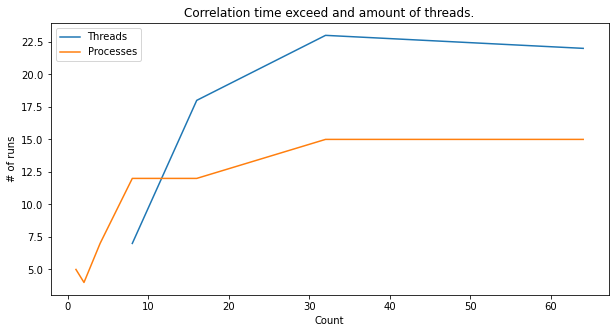

In [8]:
pack = 1

fig, ax = plt.subplots(1, figsize=(10, 5))
time_exceed = runs[
    (runs.external_time_samu == -1) & (runs.external_time_fede == -1) & (runs.packs == pack)
].groupby('threads').count()[['id']].rename(columns={'id':'Threads'})
time_exceed.plot(ax=ax)
time_exceed = runs[
    (runs.external_time_samu == -1) & (runs.external_time_fede == -1) & (runs.packs == pack)
].groupby('processes').count()[['id']].rename(columns={'id':'Processes'})
time_exceed.plot(ax=ax)
ax.set_title('Correlation time exceed and amount of threads.')
ax.set_xlabel('Count')
ax.set_ylabel('# of runs')
plt.show()

##  Interrupted by us or by full home directory

In [9]:
runs.threads.unique()

array([ 1, 16,  2, 32,  4, 64,  8])

## Correlation threads time exceed in one pack

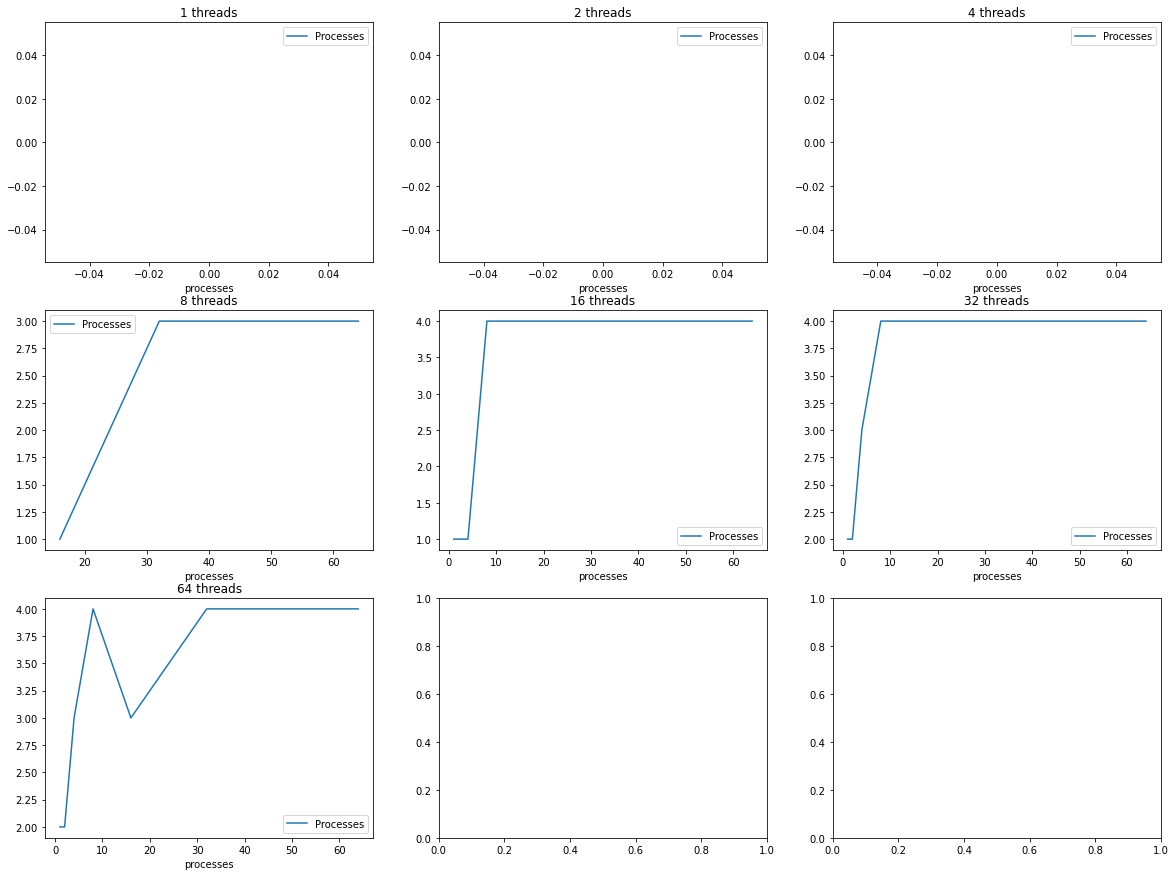

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, t in enumerate(sorted(list(runs.threads.unique()))):
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == 1)
        & (runs.threads == t)
    ].groupby('processes').count()[['id']].rename(columns={'id':'Processes'})
    ax=axs[i//3,i%3]
    ax.set_title(f"{t} threads")
    r.plot(ax=ax)
plt.show()

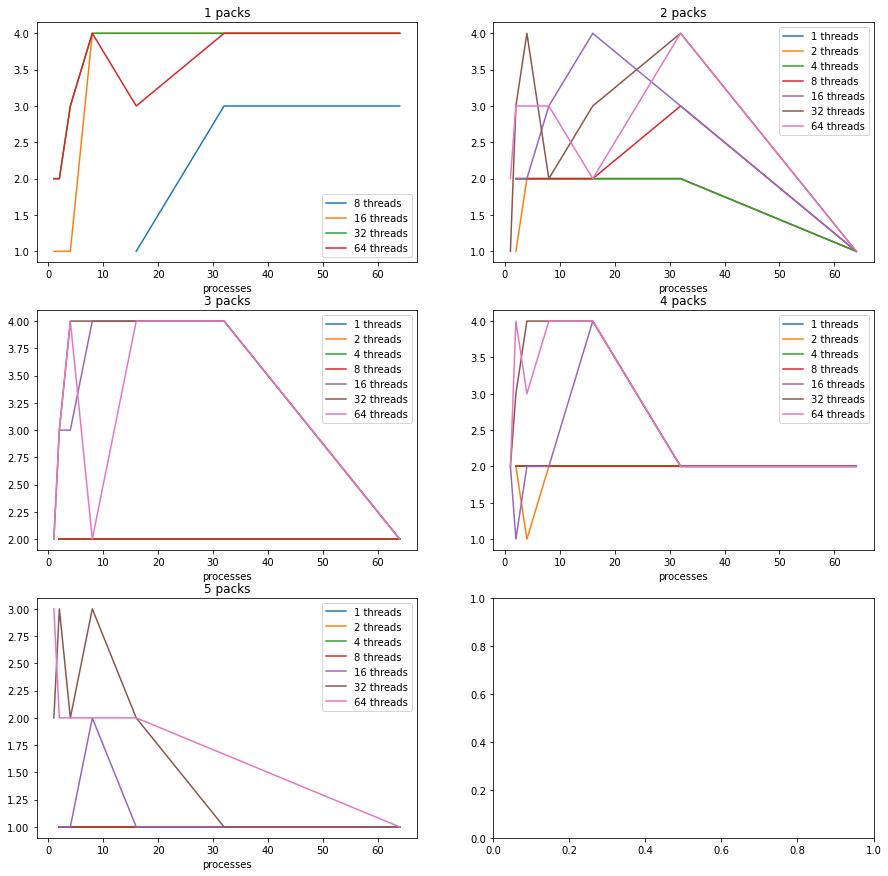

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, s in enumerate(SELECT):
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == s)
    ][['threads', 'processes', 'id']].groupby(['threads', 'processes']).count()
    ax=axs[i//2,i%2]
    ax.set_title(f"{s} packs")
    for t in r.index.get_level_values(0).unique():
        r.loc[(t,)].rename(columns={'id':f'{t} threads'}).plot(ax=ax)

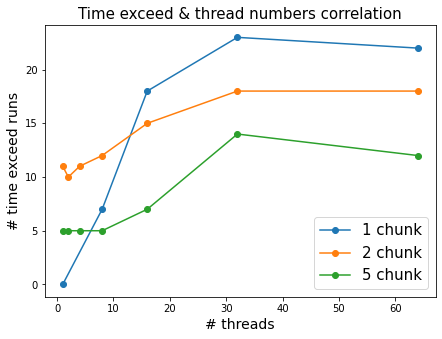

In [12]:
plt.rc('legend',fontsize=15)
fig, ax = plt.subplots(1, figsize=(7, 5))
for s in [1, 2, 5]:
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == s)
    ][['threads','id']].groupby(['threads']).count().rename(columns={'id':f'{s} chunk'})
    for t in THREADS:
        if t not in r.index:
            r.loc[t] = 0
    r.sort_index(inplace=True)
    r.plot(ax=ax, marker='o')
ax.set_xlabel('# threads', fontsize=14)
ax.set_ylabel('# time exceed runs', fontsize=14)
ax.set_title('Time exceed & thread numbers correlation', fontsize=15)
plt.savefig('../report/images/time_threads_correlation.pdf')
plt.show()

In [13]:
runs_fede = runs_fede.dropna()
runs_samu = runs_samu.dropna()
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))
len(runs)

396

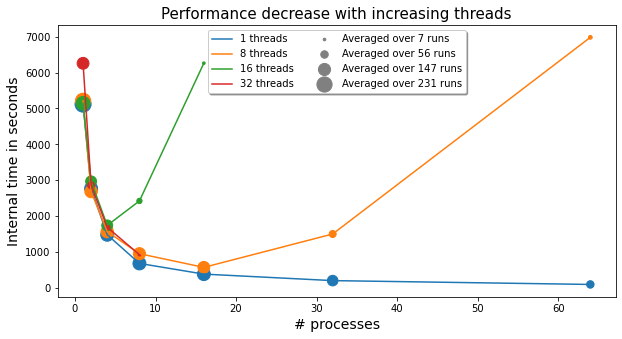

In [17]:
plt.rc('legend',fontsize=10)
fig, ax = plt.subplots(1, figsize=(10, 5))


total_sizes = []
for t in THREADS:
    A =runs[runs.threads == t][[
        'processes', 'internal_time_fede'
    ]].rename(columns={'internal_time_fede':'internal_time'})
    B =runs[runs.threads == t][[
        'processes', 'internal_time_samu'
    ]].rename(columns={'internal_time_samu':'internal_time'})
    exclusive_analysis = pd.concat([A,B])
    exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
    mean_table = exclusive_analysis.groupby('processes').agg(['mean', 'count'])
    mean_table.rename(columns={
        'internal_time': f'{t} threads'
    },inplace=True)
    mean = mean_table[(f'{t} threads', 'mean')].values
    sizes = mean_table[(f'{t} threads', 'count')].values * 7
    total_sizes.append(sizes)
    processes = mean_table.index.values
    ax.plot(processes, mean, label=f'{t} threads')
    ax.scatter(processes, mean, s=sizes, marker='o')
total_sizes = np.unique(np.concatenate(total_sizes))
total_sizes.sort()
legend_sizes = total_sizes[::(len(total_sizes)//4)+1]
for l in legend_sizes:
    plt.scatter([],[], s=l,label=f"Averaged over {l} runs", c='grey')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=2, fancybox=True, shadow=True)
ax.set_xlabel('# processes', fontsize=14)
ax.set_ylabel('Internal time in seconds', fontsize=14)
ax.set_title('Performance decrease with increasing threads', fontsize=15)
plt.savefig('../report/images/threads_performance.pdf')
plt.show()

## Exclusive or not exclusive?

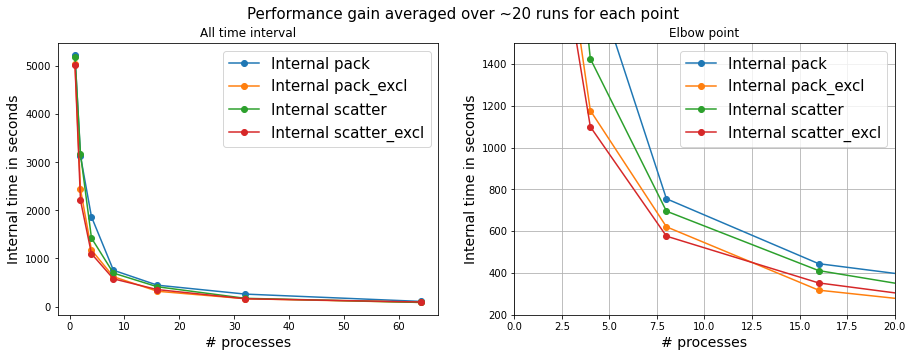

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

second = False
for ax in axs: 
    A =runs[runs.threads == 1][[
        'processes', 'place', 'external_time_fede', 'internal_time_fede'
    ]].rename(columns={'external_time_fede':'external_time', 'internal_time_fede':'internal_time'})
    B =runs[runs.threads == 1][[
        'processes', 'place', 'external_time_samu', 'internal_time_samu'
    ]].rename(columns={'external_time_samu':'external_time', 'internal_time_samu':'internal_time'})
    for p in ['pack', 'pack_excl', 'scatter', 'scatter_excl']:
        exclusive_analysis = pd.concat([A,B])
        exclusive_analysis = exclusive_analysis[exclusive_analysis.place == p].drop(columns=['place'])
        exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
        mean_table = exclusive_analysis.groupby('processes').mean()
        mean_table.rename(columns={
            'external_time': f'External {p}',
            'internal_time': f'Internal {p}'
        },inplace=True)
        mean_table.drop(columns=f'External {p}', inplace=True)
        mean_table.plot(ax=ax, marker='o')
    plt.rc('legend',fontsize=15)
    ax.set_xlabel('# processes', fontsize=14)
    ax.set_ylabel('Internal time in seconds', fontsize=14)
    if second:
        ax.set_ylim([200, 1500])
        ax.set_xlim([0, 20])
        ax.grid()
        ax.set_title('Elbow point')
    else:
        ax.set_title('All time interval')
        
    second = True
    
fig.suptitle('Performance gain averaged over ~20 runs for each point', fontsize=15)
plt.savefig('../report/images/processes_performance.pdf')
plt.show()

In [16]:
A

,processes,place,external_time,internal_time
0,1,pack,5547.935,5537.152582
1,1,pack,5156.062,5155.176323
2,1,pack,5122.271,5119.717694
3,1,pack,4972.338,4969.297061
4,1,pack,5205.286,5204.252039
...,...,...,...,...
319,8,pack_excl,590.916,587.760976
320,8,pack_excl,564.691,561.904112
321,8,pack_excl,659.950,656.117533
322,8,scatter,724.971,704.488869


/tmp/ipykernel_205020/3428871308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r = exclusive_analysis[runs.packs == s]


ValueError: Boolean array expected for the condition, not object

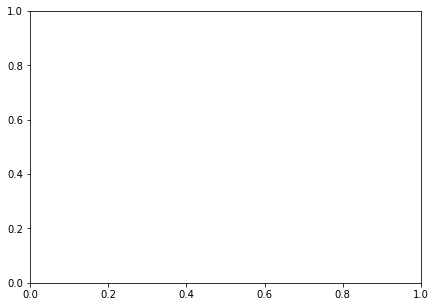

In [41]:
fig, ax = plt.subplots(1, figsize=(7, 5))
for s in [1, 2, 3, 4, 5]:
    r = exclusive_analysis[runs.packs == s]
    for p in PLACES:
        r.plot(r[r.place == p],ax=ax)
    r.sort_index(inplace=True)
plt.rc('legend',fontsize=15)
ax.set_xlabel('# threads', fontsize=14)
ax.set_ylabel('# time exceed runs', fontsize=14)
ax.set_title('Time exceed & thread numbers correlation', fontsize=15)
#plt.savefig('../report/images/time_threads_correlation.pdf')
plt.show()

## BOH

In [14]:
# There is no consistency across different runs
len(runs[runs.fitness_fede != runs.fitness_samu]), len(runs[runs.fitness_fede == runs.fitness_samu]) 

(319, 77)

In [15]:
runs['fitness_absolute_diff'] = np.abs(runs.fitness_fede - runs.fitness_samu).fillna(0)
runs.fitness_absolute_diff

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
391    0.0
392    0.0
393    0.0
394    0.0
395    0.0
Name: fitness_absolute_diff, Length: 396, dtype: float64

In [16]:
runs.fitness_absolute_diff.mean(), max(runs.fitness_fede.max(), runs.fitness_samu.max()), min(runs.fitness_fede.min(), runs.fitness_samu.min())

(1053.0326240782827, 11338.455174, 2499.697508)

In [17]:
runs['time_absolute_diff'] = np.abs(runs.internal_time_fede - runs.internal_time_samu).fillna(0)
runs.time_absolute_diff

0        0.000000
1       90.890047
2      555.720750
3      102.735450
4      152.763305
          ...    
391      0.000000
392      0.000000
393      0.000000
394      0.000000
395      0.000000
Name: time_absolute_diff, Length: 396, dtype: float64

In [18]:
runs.time_absolute_diff.mean(), max(runs.internal_time_fede.max(), runs.internal_time_samu.max()), min(runs.internal_time_fede.min(), runs.internal_time_samu.min())

(377.19456440514523, 24966.224556, 79.11064218750003)

In [19]:
runs.internal_time_fede.mean() / 60

41.78937707253567

In [20]:
runs['total'] = runs.processes * runs.packs
runs[runs.total >= 90]

,fitness_fede,internal_time_fede,external_time_fede,id,fitness_samu,internal_time_samu,external_time_samu,internal_time,processes,threads,place,packs,fitness_absolute_diff,time_absolute_diff,total
215,4307.510438,161.425060,171.796,32--1--pack--3,4307.510438,161.847242,176.180,161.636151,32,1,pack,3,0.000000,0.422181,96
218,4307.510438,161.858728,173.243,32--1--pack_excl--3,4307.510438,161.008513,174.372,161.433621,32,1,pack_excl,3,0.000000,0.850214,96
223,9239.756855,161.425200,172.021,32--2--pack--3,5368.514239,161.976487,173.075,161.700844,32,2,pack,3,3871.242616,0.551287,96
226,6588.665859,161.427331,173.127,32--2--pack_excl--3,6274.592049,161.538376,175.653,161.482854,32,2,pack_excl,3,314.073810,0.111045,96
230,5673.998215,168.162437,177.720,32--4--pack--3,6931.234932,168.133286,181.123,168.147861,32,4,pack,3,1257.236717,0.029151,96
233,7276.183002,168.312806,180.275,32--4--pack_excl--3,8174.067548,168.139727,182.168,168.226267,32,4,pack_excl,3,897.884546,0.173079,96
237,7383.764233,537.199645,548.476,32--8--pack--3,9142.518028,540.912572,551.139,539.056108,32,8,pack,3,1758.753795,3.712927,96
238,3999.495415,547.924488,560.363,32--8--pack_excl--3,7867.844341,538.179921,550.119,543.052204,32,8,pack_excl,3,3868.348926,9.744567,96


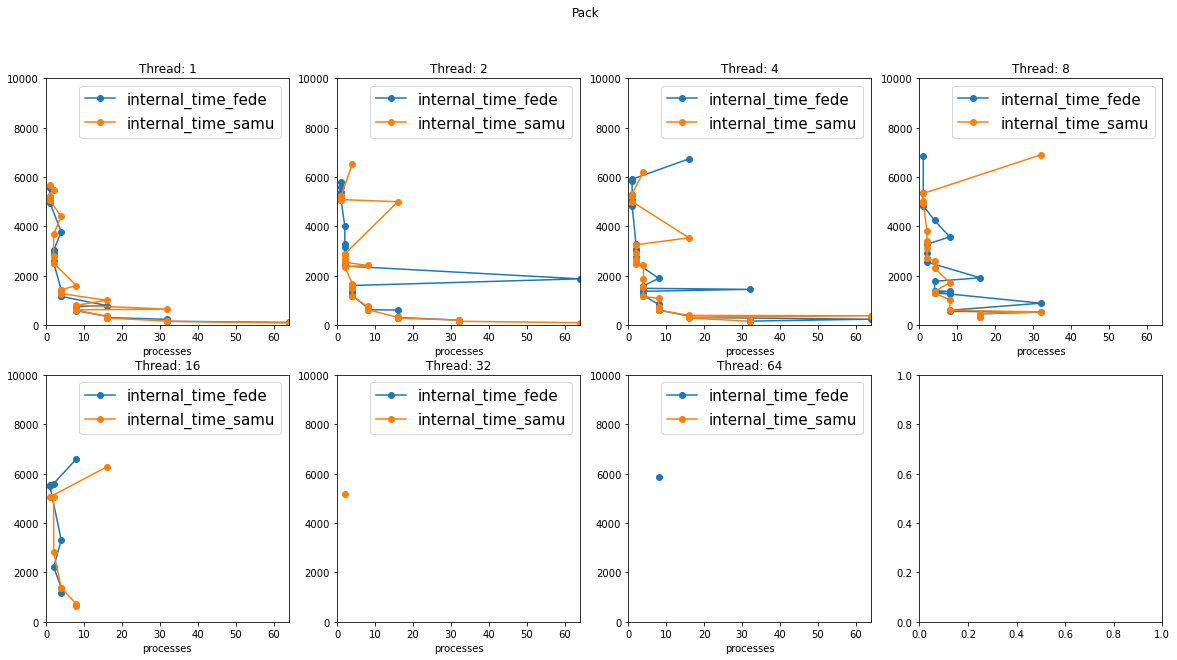

In [21]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('Pack')
plt.savefig('pack.png')
plt.show()

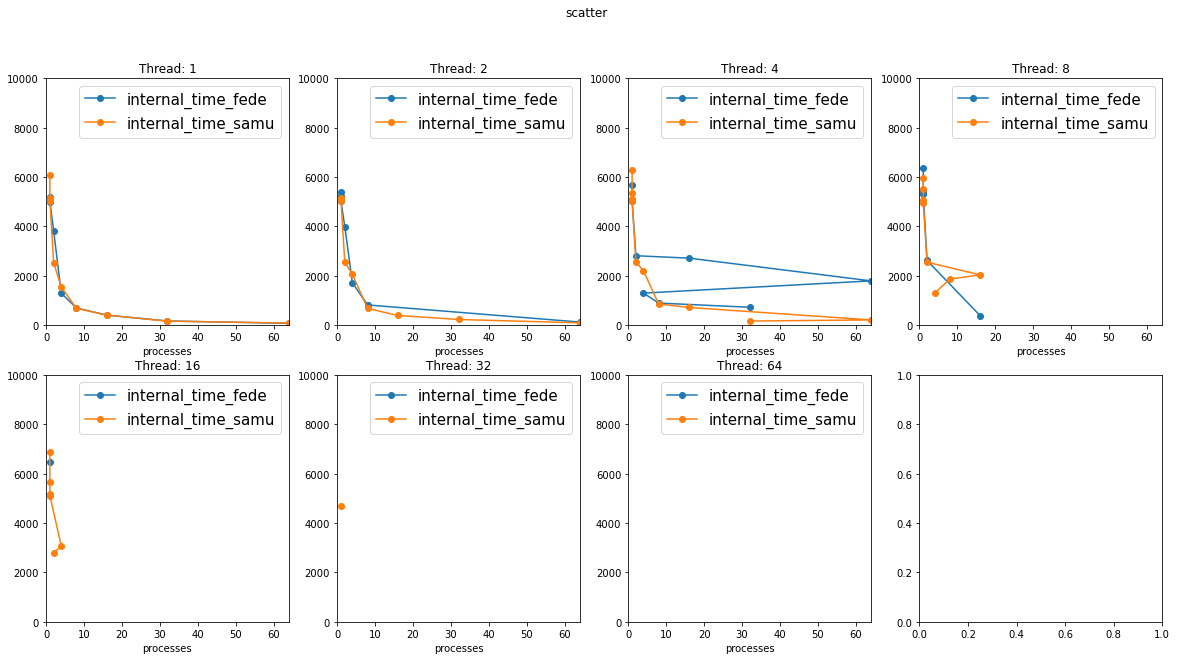

In [22]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter')
plt.savefig('scatter.png')
plt.show()

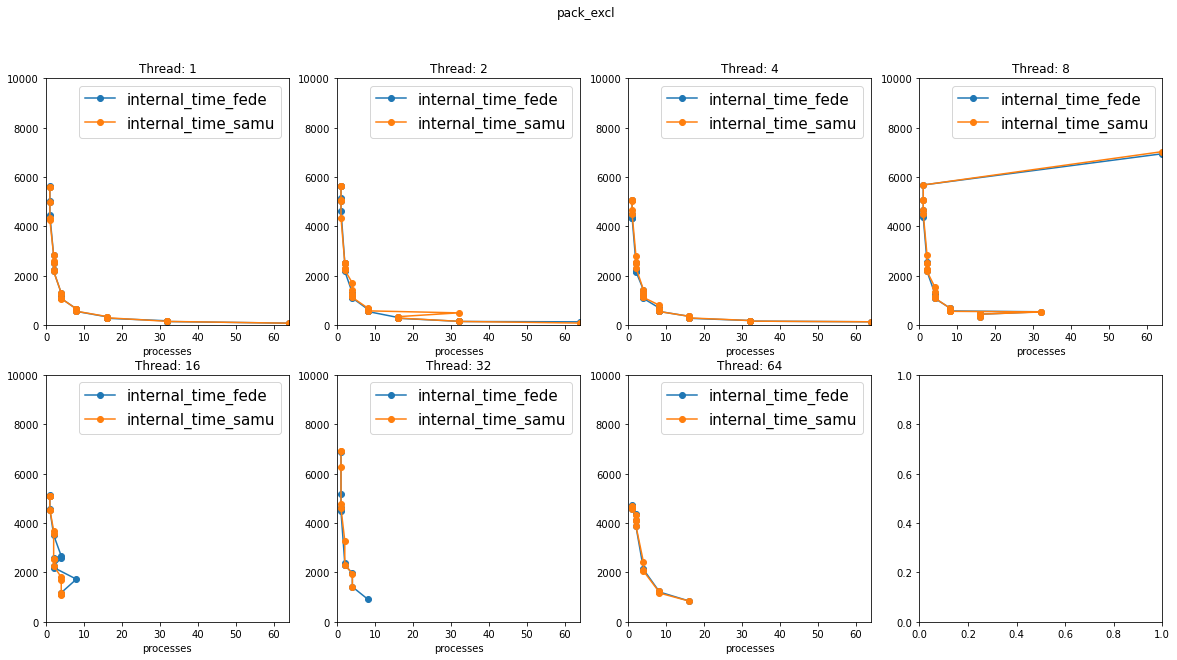

In [23]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('pack_excl')
plt.savefig('pack_excl.png')
plt.show()

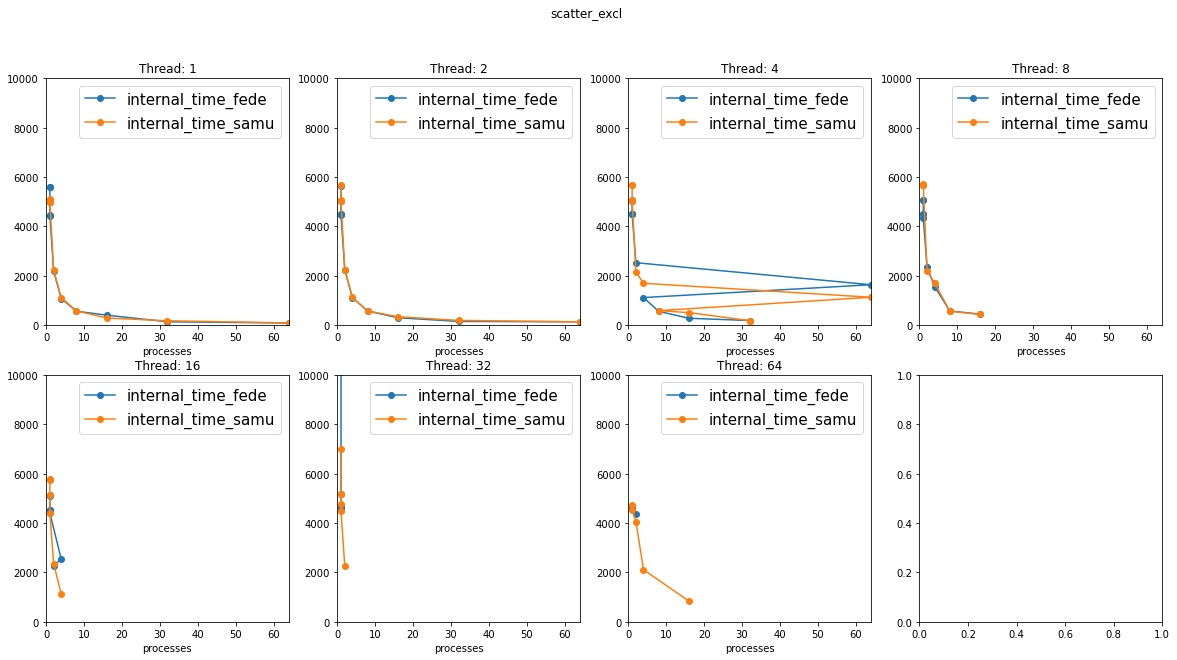

In [24]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter_excl')
plt.savefig('scatter_excl.png')
plt.show()